# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebook basic_examples.ipynb to get a flavor of *cosmofit* behaviour.
NOTE: everything that is done in this notebook is achievable through *yaml* config files, calling:
```
cosmofit profile config.yaml
cosmofit sample config.yaml
cosmofit summarize config.yaml  # for e.g. triangle plots
cosmofit do config.yaml  # to run any calculator method, e.g. plot power spectrum best fit
```
See e.g. cosmofit/tests/bao_power_pipeline.yaml

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## Likelihood

In [2]:
config = {}
config['like'] = {'class': 'cosmofit.likelihoods.PowerSpectrumMultipolesLikelihood',
                  'init': {'data': data, 'covariance': mocks,
                           'klim': {0: [0.02, 0.2], 2: [0.02, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                           'zeff': z, 'fiducial': 'DESI'}}
config['tracer'] = {'class': 'cosmofit.theories.bao.DampedBAOWigglesTracerPowerSpectrumMultipoles',
                    'init': {'mode': 'recsym'},
                     'params': {'sigma*': {'value': 0.},   # setting damping sigmas to zero, as data follows linear pk
                                '.fixed': ['al*_-3', 'al*_-2']}}  # fix some parameters to speed up calculation in this notebook
config['theory'] = {'class': 'cosmofit.theories.bao.DampedBAOWigglesPowerSpectrumMultipoles',
                    'init': {'mu': 50}}  # only 50 mu (instead of 200) to speed up calculation in this notebook
config['param'] = {'class': 'cosmofit.theories.power_template.BAOPowerSpectrumParameterization'}
                  # 'params': {'.fixed': ['qpar', 'qper']}}
config['cosmo'] = {'class': 'cosmofit.theories.primordial_cosmology.Cosmoprimo'}

# NOTE: if we wanted to fit xi instead:
# config['like'] = {'class': 'cosmofit.likelihoods.CorrelationFunctionMultipolesLikelihood',
#                   'init': {'data': data, 'covariance': mocks,
#                            'slim': {0: [40., 160], 2: [40., 160]},  # fit monopole and quadrupole, between 40 and 160 Mpc/h
#                            'zeff': z, 'fiducial': 'DESI'}}
# config['tracer'] = {'class': 'cosmofit.theories.bao.DampedBAOWigglesTracerCorrelationFunctionMultipoles',
#                     'init': {'mode': 'recsym'},
#                      'params': {'sigma*': {'value': 0.}}}
# The rest would be the same

from cosmofit import LikelihoodPipeline, setup_logging

setup_logging()

likelihood = LikelihoodPipeline(config)

[000000.62] [0/1] 09-11 20:35  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000000.63] [0/1] 09-11 20:35  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000000.66] [0/1] 09-11 20:35  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000000.69] [0/1] 09-11 20:35  PipelineConfig            INFO     No config for DampedBAOWigglesPowerSpectrumMultipoles found in config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000000.69] [0/1] 09-11 20:35  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/power_template.yaml
[000000.73] [0/1] 09-11 20:35  PipelineConfig            INFO     Loading config file /home/ade

In [3]:
from cosmofit.profilers import MinuitProfiler

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=3)

[000002.96] [0/1] 09-11 20:35  MinuitProfiler            INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1', 'bias', 'qpar', 'qper'].


In [4]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+--------------+--------+---------+-------+
| chi2 = 23.74 | varied | bestfit | error |
+--------------+--------+---------+-------+
|    al0_-1    |  True  |  -150   |  230  |
|    al0_0     |  True  |  -500   | 1300  |
|    al0_1     |  True  |  3000   | 5200  |
|    al2_-1    |  True  |  -40.   |  64   |
|    al2_0     |  True  |   10    |  650  |
|    al2_1     |  True  |   500   | 2600  |
|     bias     |  True  |  2.21   | 0.21  |
|     qpar     |  True  |  1.028  | 0.013 |
|     qper     |  True  |  1.025  | 0.022 |
+--------------+--------+---------+-------+


array([<AxesSubplot:ylabel='$\\alpha_{\\parallel}$'>,
       <AxesSubplot:ylabel='$\\alpha_{\\perp}$'>], dtype=object)

[000025.17] [0/1] 09-11 20:35  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000025.17] [0/1] 09-11 20:35  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000025.22] [0/1] 09-11 20:35  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000025.22] [0/1] 09-11 20:35  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


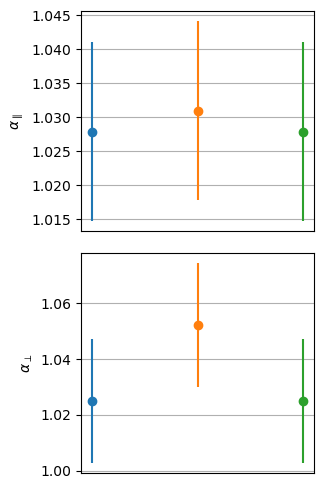

In [5]:
from cosmofit.samples import plotting
plotting.plot_aligned_stacked(profiler.profiles, params=['qpar', 'qper'])

array([<AxesSubplot:ylabel='$k P_{\\ell}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:ylabel='$\\Delta P_{0} / \\sigma_{ P_{0} }$'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$\\Delta P_{2} / \\sigma_{ P_{2} }$'>],
      dtype=object)

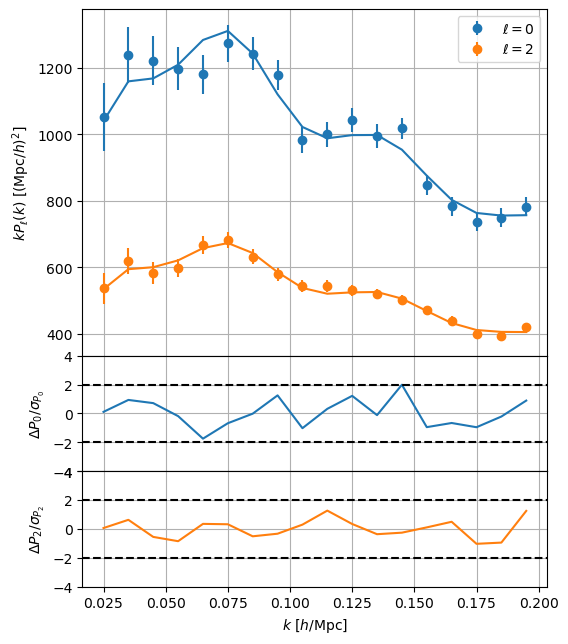

In [6]:
likelihood.run(**profiler.profiles.bestfit.choice())
likelihood.end_calculators[0].plot()

array([<AxesSubplot:ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

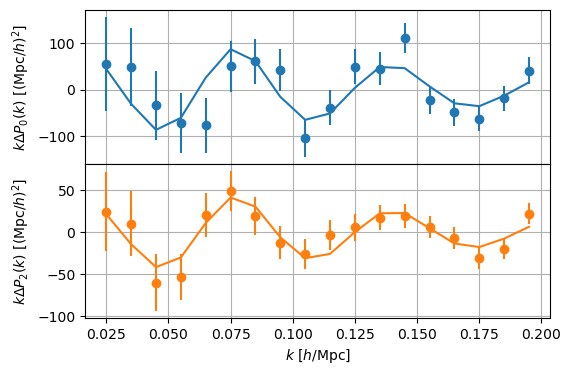

In [7]:
likelihood.end_calculators[0].plot_bao()

## Detection level

In [8]:
config['tracer']['params']['.fixed'] = 'al*'  # fixing some broadband parameters to speed calculation in this notebook
config['tracer']['params']['.varied'] = 'al*_0'
config['tracer']['init']['nowiggle'] = True  # remove wiggles
config['param']['init'] = {'mode': 'qiso'}  # switch to qiso only
likelihood = LikelihoodPipeline(config)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], size=40, cl=8)
profiles_nowiggle = profiler.profiles

[000027.18] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000027.18] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000027.20] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000027.22] [0/1] 09-11 20:36  PipelineConfig            INFO     No config for DampedBAOWigglesPowerSpectrumMultipoles found in config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000027.22] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/power_template.yaml
[000027.27] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/ade

In [9]:
config['tracer']['init']['nowiggle'] = False
likelihood = LikelihoodPipeline(config)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], size=40, cl=8)
profiles = profiler.profiles

[000037.05] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000037.05] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000037.07] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000037.08] [0/1] 09-11 20:36  PipelineConfig            INFO     No config for DampedBAOWigglesPowerSpectrumMultipoles found in config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000037.08] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/power_template.yaml
[000037.11] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/ade

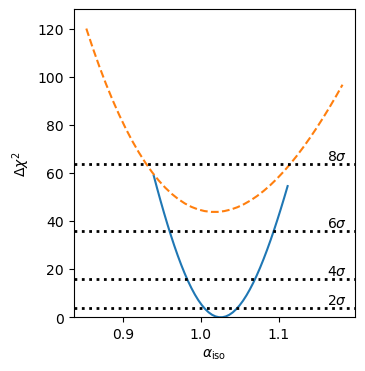

In [10]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[2, 4, 6, 8])
# Orange curve is no-wiggle:
# Some qiso information is picked up by the broadband because we did not include enough broadband terms

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [11]:
# We fit to the mean of the mocks to get qiso close to 1
config['like']['init']['data'] = config['like']['init']['covariance']
# Rescale covariance by number of data realizations
config['like']['init']['covariance_scale'] = True
# Provide reference distrubution (used to sample initial points) to speed up convergence
config['tracer']['params']['al*'] = {'ref': {'dist': 'uniform', 'limits': [-20, 20]}}
config['tracer']['params']['bias'] = {'ref': {'dist': 'uniform', 'limits': [1.95, 2.05]}}
config['param']['params'] = {'qiso': {'ref': {'dist': 'uniform', 'limits': [0.99, 1.01]}}}

likelihood = LikelihoodPipeline(config)

from cosmofit.samplers import EmceeSampler, ZeusSampler

sampler = EmceeSampler(likelihood, seed=42, nwalkers=None)
converged = False
while not converged:
    sampler.run(niterations=500)
    converged = sampler.check(eigen_gr_stop=0.04)

[000044.97] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000044.98] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000045.01] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000045.03] [0/1] 09-11 20:36  PipelineConfig            INFO     No config for DampedBAOWigglesPowerSpectrumMultipoles found in config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/bao.yaml
[000045.03] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/power_template.yaml
[000045.06] [0/1] 09-11 20:36  PipelineConfig            INFO     Loading config file /home/ade

[000141.04] [0/1] 09-11 20:37  EmceeSampler              INFO     - max Geweke is 0.333.
[000141.09] [0/1] 09-11 20:37  EmceeSampler              INFO     - max integrated autocorrelation time is 61.2.
[000141.10] [0/1] 09-11 20:37  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0498.
[000152.41] [0/1] 09-11 20:38  EmceeSampler              INFO     Diagnostics:
[000152.44] [0/1] 09-11 20:38  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0898 > 0.04.
[000152.47] [0/1] 09-11 20:38  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0648.
[000152.53] [0/1] 09-11 20:38  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0574.
[000152.54] [0/1] 09-11 20:38  EmceeSampler              INFO     - max Geweke is 0.393.
[000152.59] [0/1] 09-11 20:38  EmceeSampler              INFO     - max integrated autocorrelation time is 56.4 (reliable).
[000152.59] [0/1] 09-11 20:38  EmceeSampl

[000201.11] [0/1] 09-11 20:38  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in
[000201.44] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: al0_0, al2_0
[000201.52] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: al0_0, bias
[000201.61] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: al0_0, qiso
[000201.70] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: al2_0, bias
[000201.78] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: al2_0, qiso
[000201.85] [0/1] 09-11 20:38  root                      WARNING  fine_bins_2D not large enough for optimal density: bias, qiso


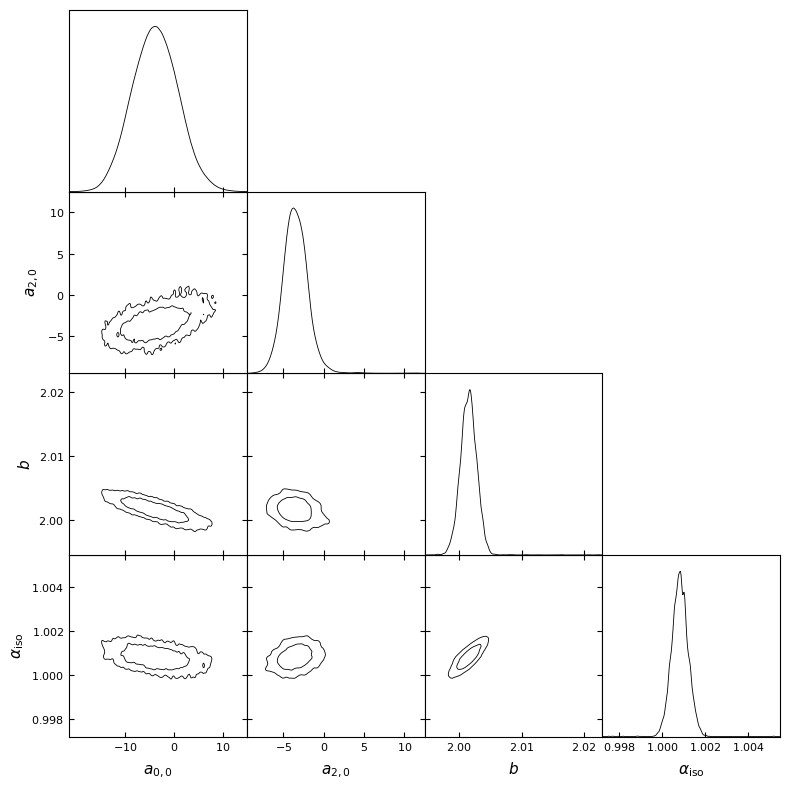

In [12]:
chain = sampler.chains[0].remove_burnin(0.5)
plotting.plot_triangle(chain)

## Post-processing

In [13]:
bao_chain = sampler.chains[0]

In [14]:
config = {}
config['like'] = {'class': 'cosmofit.likelihoods.BAOParameterizationLikelihood',
                  'init': {'chains': bao_chain, 'burnin': 0.5}}
config['cosmo'] = {'class': 'cosmofit.theories.primordial_cosmology.Cosmoprimo',
                   'init': {'fiducial': 'DESI'},
                   'params': {'.delete': 'omega_cdm',
                              'Omega_m': {'fixed': False, 'prior': {'dist': 'uniform', 'limits': [0.05, 0.6]},
                                                          'ref': {'dist': 'uniform', 'limits': [0.2, 0.4]},
                                                          'latex': '\Omega_{m}'}}}
likelihood = LikelihoodPipeline(config)

[000203.07] [0/1] 09-11 20:38  PipelineConfig            INFO     Loading config file /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/primordial_cosmology.yaml
[000203.62] [0/1] 09-11 20:38  LikelihoodPipeline        INFO     Found calculators [BAOParameterizationLikelihood(like), BAOModel(theory), Cosmoprimo(cosmo)].
[000203.62] [0/1] 09-11 20:38  LikelihoodPipeline        INFO     Found end calculators [BAOParameterizationLikelihood(like)].
[000203.73] [0/1] 09-11 20:38  BAOParameterizationLikelihood INFO     Fitting input samples [Parameter(DV_over_rd, fixed)].
[000203.74] [0/1] 09-11 20:38  LikelihoodPipeline        INFO     Found likelihood like.


In [15]:
from cosmofit.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42, nwalkers=4)
converged = False
while not converged:
    sampler.run(niterations=500)
    converged = sampler.check(eigen_gr_stop=0.03)

[000203.76] [0/1] 09-11 20:38  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000324.41] [0/1] 09-11 20:40  EmceeSampler              INFO     Diagnostics:
[000324.41] [0/1] 09-11 20:40  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0337 > 0.03.
[000324.42] [0/1] 09-11 20:40  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0337.
[000324.42] [0/1] 09-11 20:40  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.366.
[000324.42] [0/1] 09-11 20:40  EmceeSampler              INFO     - max Geweke is 0.485.
[000324.43] [0/1] 09-11 20:40  EmceeSampler              INFO     - max integrated autocorrelation time is 20.
[000444.11] [0/1] 09-11 20:42  EmceeSampler              INFO     Diagnostics:
[000444.11] [0/1] 09-11 20:42  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0466 > 0.03.
[000444.12] [0/1] 09-11 20:42  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 i

Removed no burn in


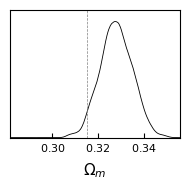

In [16]:
chain = sampler.chains[0].remove_burnin(0.5)
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m})